# POST PROCESSING FILE

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, MultiPolygon, Polygon
from shapely.ops import nearest_points
from shapely.geometry import shape
from shapely.geometry import LineString
import searoute as sr
import numpy as np
import geojson
import json
from tqdm import tqdm
from pprint import pprint
pd.set_option('display.max_columns', None)

In [2]:
def plot_vessel_positions(df, land_file='ne_10m_land.zip'):
    # Create geometry column from longitude and latitude
    geometry = [Point(xy) for xy in zip(df['longitude_predicted'], df['latitude_predicted'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    
    # Load world map data from the Natural Earth file
    world = gpd.read_file(land_file)
    
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Plot the world map
    world.plot(ax=ax, alpha=0.5, color='lightgray')
    
    # Generate unique colors for each vessel
    unique_vessels = df['vesselId'].unique()
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_vessels)))
    
    # Plot each vessel's points with a unique color and black edge
    for vessel, color in zip(unique_vessels, colors):
        vessel_data = gdf[gdf['vesselId'] == vessel]
        vessel_data.plot(ax=ax, marker='o', color=color, markersize=20, alpha=0.7,
                        edgecolor='black', linewidth=1)
    
    # Remove axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add gridlines
    ax.grid(True, linestyle='--', alpha=0.6)
    
    plt.axis('off')  # Remove all axes
    
    return fig, ax

In [ ]:
# LOAD
df = pd.read_csv('results_2.3.csv', sep=',')

test = pd.read_csv('ais_test.csv', sep=',')
test = test.drop(columns=['scaling_factor']) 
show = pd.merge(df, test, on='ID', how='left')
show['time'] = pd.to_datetime(show['time'])
show.head()

,ID,longitude_predicted,latitude_predicted,vesselId,time
0,0,-80.941090,31.264187,61e9f3aeb937134a3c4bfe3d,2024-05-08 00:03:16
1,1,119.937454,15.943081,61e9f473b937134a3c4c02df,2024-05-08 00:06:17
2,2,10.746855,38.867760,61e9f469b937134a3c4c029b,2024-05-08 00:10:02
3,3,172.998430,-43.347828,61e9f45bb937134a3c4c0221,2024-05-08 00:10:34
4,4,-5.669545,48.539047,61e9f38eb937134a3c4bfd8d,2024-05-08 00:12:27


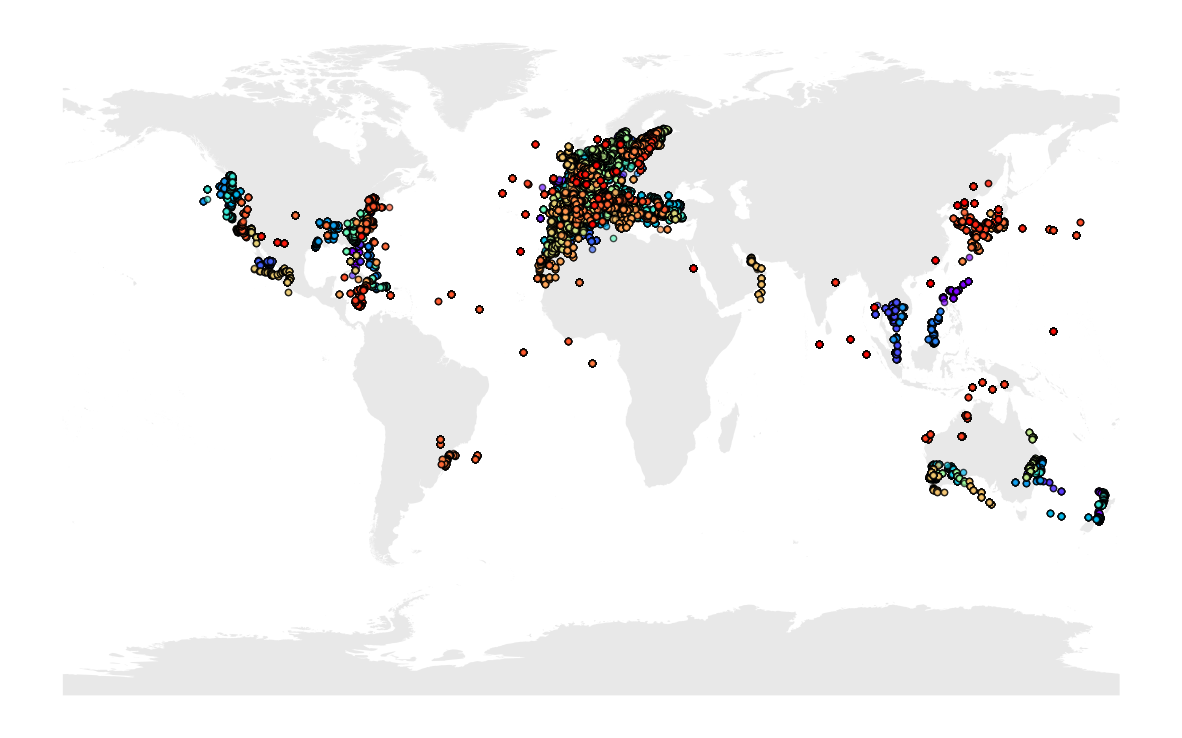

In [14]:
fig, ax = plot_vessel_positions(show)
plt.show()

In [5]:
land_world = gpd.read_file('ne_10m_land/ne_10m_land.shp').to_crs(4326)
ocean_world = gpd.read_file('ne_10m_ocean/ne_10m_ocean.shp').to_crs(4326)
gdf = gpd.GeoDataFrame(show, geometry=gpd.points_from_xy(df['longitude_predicted'], df['latitude_predicted'], crs="EPSG:4326"))
gdf.head()

,ID,longitude_predicted,latitude_predicted,vesselId,time,geometry
0,0,-80.941090,31.264187,61e9f3aeb937134a3c4bfe3d,2024-05-08 00:03:16,POINT (-80.94109 31.26419)
1,1,119.937454,15.943081,61e9f473b937134a3c4c02df,2024-05-08 00:06:17,POINT (119.93745 15.94308)
2,2,10.746855,38.867760,61e9f469b937134a3c4c029b,2024-05-08 00:10:02,POINT (10.74686 38.86776)
3,3,172.998430,-43.347828,61e9f45bb937134a3c4c0221,2024-05-08 00:10:34,POINT (172.99843 -43.34783)
4,4,-5.669545,48.539047,61e9f38eb937134a3c4bfd8d,2024-05-08 00:12:27,POINT (-5.66955 48.53905)


In [6]:
# Check if point is on land
points_on_land = gpd.sjoin(gdf, land_world, how="inner", predicate="within")

In [7]:
closest_longitudes = []
closest_latitudes = []
for _, row in points_on_land.iterrows():
    closest_point, _ = nearest_points(ocean_world['geometry'], row['geometry'])
    closest_longitudes.append(closest_point.x)
    closest_latitudes.append(closest_point.y)


In [8]:
points_on_land['closest_longitude'] = closest_longitudes
points_on_land['closest_latitude'] = closest_latitudes

In [9]:
points_on_land.head()

,ID,longitude_predicted,latitude_predicted,vesselId,time,geometry,index_right,featurecla,scalerank,min_zoom,closest_longitude,closest_latitude
1,1,119.937454,15.943081,61e9f473b937134a3c4c02df,2024-05-08 00:06:17,POINT (119.93745 15.94308),0,Land,0.0,0.0,0 119.878917 dtype: float64,0 15.91474 dtype: float64
6,6,-8.481432,43.321040,61e9f3c7b937134a3c4bfedf,2024-05-08 00:13:58,POINT (-8.48143 43.32104),0,Land,0.0,0.0,0 -8.497548 dtype: float64,0 43.337795 dtype: float64
8,8,29.565992,40.947760,61e9f446b937134a3c4c01ab,2024-05-08 00:15:03,POINT (29.56599 40.94776),0,Land,0.0,0.0,0 29.571236 dtype: float64,0 40.780537 dtype: float64
11,11,-5.766801,43.441822,61e9f469b937134a3c4c0295,2024-05-08 00:16:00,POINT (-5.76680 43.44182),0,Land,0.0,0.0,0 -5.708852 dtype: float64,0 43.56863 dtype: float64
12,12,18.429554,54.349976,630fede7698dd2548ac1ee66,2024-05-08 00:16:24,POINT (18.42955 54.34998),0,Land,0.0,0.0,0 18.574067 dtype: float64,0 54.450385 dtype: float64


In [10]:
gdf.loc[points_on_land.index, 'longitude_predicted'] = points_on_land['closest_longitude']
gdf.loc[points_on_land.index, 'latitude_predicted'] = points_on_land['closest_latitude']

In [11]:
gdf['longitude_predicted'] = gdf['longitude_predicted'].astype(float)
gdf['latitude_predicted'] = gdf['latitude_predicted'].astype(float)
gdf.head()

/var/folders/_k/_j2m440s1cdcpmdx7hff9q0r0000gn/T/ipykernel_17445/3195599312.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gdf['longitude_predicted'] = gdf['longitude_predicted'].astype(float)
/var/folders/_k/_j2m440s1cdcpmdx7hff9q0r0000gn/T/ipykernel_17445/3195599312.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gdf['latitude_predicted'] = gdf['latitude_predicted'].astype(float)


,ID,longitude_predicted,latitude_predicted,vesselId,time,geometry
0,0,-80.941090,31.264187,61e9f3aeb937134a3c4bfe3d,2024-05-08 00:03:16,POINT (-80.94109 31.26419)
1,1,119.878917,15.914740,61e9f473b937134a3c4c02df,2024-05-08 00:06:17,POINT (119.93745 15.94308)
2,2,10.746855,38.867760,61e9f469b937134a3c4c029b,2024-05-08 00:10:02,POINT (10.74686 38.86776)
3,3,172.998430,-43.347828,61e9f45bb937134a3c4c0221,2024-05-08 00:10:34,POINT (172.99843 -43.34783)
4,4,-5.669545,48.539047,61e9f38eb937134a3c4bfd8d,2024-05-08 00:12:27,POINT (-5.66955 48.53905)


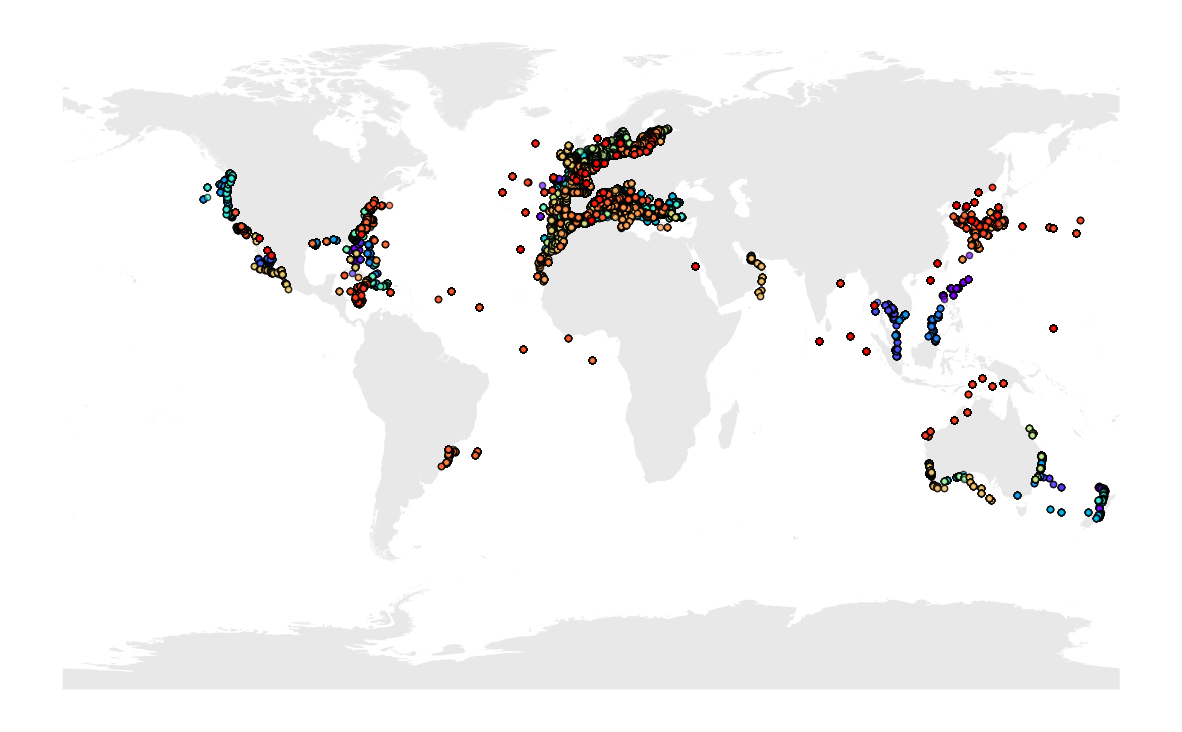

In [13]:
fig, ax = plot_vessel_positions(gdf)
plt.show()

In [223]:
gdf = gdf.drop(columns=['vesselId', 'time', 'geometry'])

In [224]:
gdf.to_csv('processed_res.csv')